# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')
# --------------------------------------------------

# --------------------------------------------------
# load datasets
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # pd.get_dummies
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA


# Classifier ---------------------------------------

# estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression # classifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# --------------------------------------------------

# Regressor-----------------------------------------
# estimators
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostError
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# --------------------------------------------------

# stats : R module
from scipy.stats import skew, kurtosis

# model_selection.splitter
from sklearn.model_selection import train_test_split       # function
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold # cross-validator
from sklearn.model_selection import cross_val_score, cross_validate
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV

# **************************************************

# --------------------------------------------------
def check_nan(df):
    nan = df.isna().sum()[df.isna().sum() != 0]
    nan_cols = list(nan.index)
    nan_cnt  = df[nan_cols].isna().sum()
    rate = round(nan_cnt / df.shape[0] * 100, 2)
    nan_df = pd.DataFrame({'NAN_CNT':nan_cnt, 'RATE':rate})
    
    print(nan_df)
    print('-' * 30)
    print('nan_cols count =', len(nan_cols))
    print(nan_cols)
 
    for col in nan_cols:
        print('-' * 30)
        print(df[col].value_counts())
        print('value_counts =', df[col].count(), '/ nan_counts =', df[col].isna().sum())
    
    return nan_cols
# nan_cols = check_nan(df)
# --------------------------------------------------

# --------------------------------------------------
def check_outliers(X_train, features, rate=1.5):
    
    dict = {}
    
    for col in features:
        
        Q1 = np.percentile(X_train[col], 25) 
        Q3 = np.percentile(X_train[col], 75) 
        IQR = Q3 - Q1
        
        min = Q1 - (rate * IQR)
        max = Q3 + (rate * IQR)
        
        idxs = X_train[(X_train[col] < min) | (X_train[col] > max)].index
        
        dict[col] = idxs
        
    return dict
# check_outliers(X_train, 'Insulin')
# --------------------------------------------------

# --------------------------------------------------
def check_object(df):
    object_cols = list(df.dtypes[df.dtypes == 'object'].index)
    print('object_cols count =', len(object_cols))
    for col in object_cols:
        print('-' * 30)
        print(df[col].value_counts())
    return object_cols
# object_cols = encode(df)
# --------------------------------------------------

# --------------------------------------------------
def mapping(df, col, dict):
    dict = {}
    
    for i in range(len(df[col].value_counts().index)):
        dict[df[col].value_counts().index[i]] = i
    
    df['e_' + col] = df[col].map(dict)
    return df['e_' + col].value_counts()
# mapping(df, 'gender')
# --------------------------------------------------

# --------------------------------------------------
def split_xy(df, target, test_size=0.2):
    
    """split X, y & train, test"""
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = split_xy(df, 'Outcome')
# --------------------------------------------------

# --------------------------------------------------
def scores(y_test, y_pred):
    
    """evaluation scores"""
    
    f1        = f1_score         (y_test, y_pred, average='macro')
    accuracy  = accuracy_score   (y_test, y_pred, )
    precision = precision_score  (y_test, y_pred, average='macro')
    recall    = recall_score     (y_test, y_pred, average='macro')
    c_matrix  = confusion_matrix (y_test, y_pred, )
    
    print(
          f'accuracy  = {accuracy:.6f},  '
          f'f1 score  = {f1:.6f},  \n'
          f'precision = {precision:.6f},  '
          f'recall    = {recall:.6f},')
    print(c_matrix)
    
    # plt.figure(figsize=(12, 9))
    # plt.title('confusion matrix')
    # plt.xlabel('Predict')
    # plt.ylabel('Actual')
    # sns.heatmap(c_matrix, annot=True, linewidths=1, cmap='Blues', annot_kws={"size": 14})
    # plt.show()
# --------------------------------------------------

# --------------------------------------------------
def curves(y_test, probas_pred):
        
    FPRS, TPRS, thresholds = roc_curve(y_test, probas_pred[:, 1])
 
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
 
    # settings
    plt.subplot(121)
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')
 
    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')
    plt.legend()
 
    precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
 
    plt.subplot(122)
    plt.title('precision recall curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('scores')
 
    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.legend()
 
    plt.show()
    
    print('AUC = ', roc_auc_score(y_test, probas_pred[:, 1]))
# --------------------------------------------------

## metrics

In [2]:
# # classification cross_validate : INPUT DF VERSION & TARGET
# # ==================================================
# df_met     = df00
# target_met = 'target'
# # ==================================================

# # X, y split
# train_met = df_met[df_met[target_met].notna()]
# X_met = train_met.drop(target_met, axis=1)
# y_met = train_met[target_met]

# # estimators=
# classification_models = [RandomForestClassifier(random_state=0),
#                          GradientBoostingClassifier(random_state=0),
#                          XGBClassifier(random_state=0),
#                          XGBRFClassifier(random_state=0),
#                          LGBMClassifier(random_state=0),
#                          CatBoostClassifier(random_state=0),
#                          ]

# # scorings=
# classification_scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
#                           'precision':'precision_macro', 'recall':'recall_macro', 
#                           'roc_auc_ovr':'roc_auc_ovr',}

# # cv=
# kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cross_validate loop
# for model in classification_models:
    
#     cv_results = cross_validate(model, X_met, y_met,
#                                 scoring=classification_scorers,
#                                 cv=skf,
#                                 return_train_score=True, return_estimator=True)
    
#     print('-' * 70)
#     print('model  =', model.__class__.__name__)
#     print('params =', model.get_params(deep=True))
    
#     # classification metrics
#     print('f1_macro  = {}  '.format(cv_results['test_f1_macro'].mean()),
#           'accuracy  = {}  '.format(cv_results['test_accuracy'].mean()), '\n'
#           'precision = {}  '.format(cv_results['test_precision'].mean()),
#           'recall    = {}  '.format(cv_results['test_recall'].mean()), '\n'
#           'AUC_ovr   = {}  '.format(cv_results['test_roc_auc_ovr'].mean()),
#           )
    
#     fi_list = []
#     for idx, estimator in enumerate(cv_results['estimator']):
#         fi = pd.DataFrame(estimator.feature_importances_, 
#                           index=X_met.columns, columns=['importance']).sort_values('importance', ascending=False)
        
#         fi_list.append(estimator.feature_importances_.tolist())
#     fi_means = np.array(fi_list).mean(axis=0)
#     fi_df = pd.DataFrame(fi_means, columns=['importance'], index=X_met.columns).sort_values(by='importance', ascending=False)
#     fig, ax = plt.subplots(figsize=(16, 12))
#     sns.set_theme(style='whitegrid')
#     sns.set_color_codes('pastel')
#     sns.barplot(x='importance', y_met=X_met.columns, data=fi_df)
#     plt.show()

In [3]:
# # classification GridsearchCV : INPUT DF VERSION & TARGET
# # ==================================================
# df_met     = df00
# target_met = 'target'
# # ==================================================

# # X, y split
# train_met = df_met[df_met[target_met].notna()]
# X_met = train_met.drop(target_met, axis=1)
# y_met = train_met[target_met]

# # models
# classification_models = [RandomForestClassifier(),
#                          GradientBoostingClassifier(),
#                          XGBClassifier(), 
#                          XGBRFClassifier(), 
#                          LGBMClassifier(), 
#                          CatBoostClassifier(),
#                          ]

# # param_grid=
# hyper_param = {'n_estimators':[100],
#                'random_state':[0],
#               #  'min_samples_split':[2],
#               #  'min_samples_leaf':[1],
#                }

# # scoring=
# classification_scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
#                           'precision':'precision_macro', 'recall':'recall_macro', 
#                           'roc_auc_ovr':'roc_auc_ovr',}

# # cv=
# kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cv_results_ cols
# classification_cols = ['mean_test_f1_macro', 'mean_test_accuracy', 
#                        'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc_ovr',]

# # GridSearchCV loop
# for model in classification_models:
        
#         gscv = GridSearchCV(model, param_grid=hyper_param, 
#                             scoring=classification_scorers, refit='f1_macro', 
#                             cv=skf, return_train_score=True)
#         gscv.fit(X_met, y_met)
#         results = gscv.cv_results_
        
#         print('-' * 75)
#         print('estimtor        =', gscv.estimator)
#         print('best_params_    =', gscv.best_params_)
#         print('best_score_     =', gscv.best_score_)
        
#         met_df = pd.DataFrame(results)[classification_cols]
#         met_df.columns = ['f1_macro', 'accuracy', 'precision', 'recall', 'auc_ovr',]
#         print(met_df)

In [4]:
# # regression cross_validate : INPUT DF VERSION & TARGET
# # ==================================================
# df_met     = df00
# target_met = 'target'
# # ==================================================

# # X, y split
# train_met = df_met[df_met[target_met].notna()]
# X_met = train_met.drop(target_met, axis=1)
# y_met = train_met[target_met]

# # estimators=
# regressor_models = [
#                     # LinearRegression(),
#                     # RandomForestRegressor(random_state=0),
#                     Ridge(random_state=0),
#                     Lasso(random_state=0),
#                     ElasticNet(random_state=0),
#                     DecisionTreeRegressor(random_state=0),
#                     XGBRegressor(random_state=0),
#                     LGBMRegressor(random_state=0),
#                     # CatBoostRegressor(random_state=0),
#                     ]

# # scorings=
# regressor_scorers = {'MSE':'neg_mean_squared_error',
#                      'RMSE':'neg_root_mean_squared_error',
#                     #  'MSLE':'neg_mean_squared_log_error',
#                     #  'MAE':'neg_mean_absolute_error',
#                      }

# # cv=
# kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cross_validate loop
# for model in regressor_models:
    
#     cv_results = cross_validate(model, X_met, y_met,
#                                 scoring=regressor_scorers,
#                                 cv=kf,
#                                 return_train_score=True, return_estimator=True)
    
#     print('-' * 40)
#     print('model  =', model.__class__.__name__)
#     # print('params =', model.get_params(deep=True))
    
#     # regression metrics
#     print('MSE    = {}  '.format(- cv_results['test_MSE'].mean()), '\n'
#           'RMSE   =  {}  '.format(- cv_results['test_RMSE'].mean()),
#         #   'MSLE   = {}  '.format(- cv_results['test_MSLE'].mean()),
#         #   'MAE    = {}  '.format(- cv_results['test_MAE'].mean()),
#           )

In [5]:
# # regression GridsearchCV : INPUT DF VERSION & TARGET
# # ==================================================
# df_met     = df00
# target_met = 'target'
# # ==================================================

# # X, y split
# train_met = df_met[df_met[target_met].notna()]
# X_met = train_met.drop(target_met, axis=1)
# y_met = train_met[target_met]

# # models
# regressor_models = [
#                     # LinearRegression(),
#                     # RandomForestRegressor(),
#                     Ridge(),
#                     Lasso(),
#                     ElasticNet(),
#                     DecisionTreeRegressor(),
#                     XGBRegressor(),
#                     LGBMRegressor(),
#                     # CatBoostRegressor(),
#                     ]

# # param_grid=
# hyper_param = {
#                'random_state':[0],
#                }

# # scoring=
# regressor_scorers = {'MSE':'neg_mean_squared_error',
#                      'RMSE':'neg_root_mean_squared_error',
#                     #  'MSLE':'neg_mean_squared_log_error',
#                     #  'MAE':'neg_mean_absolute_error',
#                      }

# # cv=
# kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # cv_results_ cols
# regression_cols = ['mean_test_MSE', 'mean_test_RMSE', 
#                 #    'mean_test_MSLE', 'mean_test_MAE',
#                    ]

# # GridSearchCV loop
# for model in regressor_models:
        
#         gscv = GridSearchCV(model, 
#                             param_grid=hyper_param, 
#                             scoring=regressor_scorers, refit='RMSE', 
#                             cv=kf, return_train_score=True)
#         gscv.fit(X_met, y_met)
#         results = gscv.cv_results_
        
#         print('-' * 40)
#         print('estimtor        =', gscv.estimator.__class__.__name__)
#         print('best_params_    =', gscv.best_params_)
#         print('best_score_     =', - gscv.best_score_)
        
#         met_df = pd.DataFrame(results)[regression_cols]
#         met_df.columns = ['MSE', 'RMSE', 
#                         #   'MSLE', 'MAE',
#                           ]
#         print(- met_df)

# statistics

In [6]:
# 중심경향값   : 평균, 중앙값, 최빈값
# 산포도(퍼짐) : 표준편차, 분산, 범위, 사분위수
# 분포도(모양) : skew, kurtosis

# 정규분포 : 평균을 중심으로 좌우대칭 형태
# 중심극한 : 중심극한의 정리(CLT, Central Limit Theorem)
#           표본의 평균은 표본의 개수(n)가 커질수록, 정규분포와 유사해진다.
#           표본의 수가 충분히 크다면, 정규분포라고 가정할 수 있다.(n > 30)

# np.power  : 제곱(**)
# np.sqrt   : 제곱근

In [7]:
# 평균 np.mean() : sample sum / sample count
list = [1, 2, 3, 4, 5]
평균 = np.mean(list); 평균

3.0

In [8]:
# 편차 : sample - mean
dev_list = []
for i in list:
    dev_list.append(평균-i)    
dev_list

[2.0, 1.0, 0.0, -1.0, -2.0]

In [9]:
# 분산 np.var() : dev^2 mean
분산 = np.square(dev_list).mean(); 분산

2.0

In [10]:
np.var(list)

2.0

In [11]:
# 표준편차 np.std() : var 제곱근
np.sqrt(분산)

1.4142135623730951

In [12]:
np.std(list)

1.4142135623730951

# regression

## read boston

In [13]:
# https://www.kaggle.com/vikrishnan/boston-house-prices?
boston = datasets.load_boston()
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']

# feature description
# crim	  자치시(town)별 1인당 범죄율
# zn	  25,000 평방 피트를 초과하는 거주지역의 비율
# indus	  비소매상업지역이 차지하고 있는 토지의 비율
# chas	  찰스강의 경계에 위치한 경우는 1, 아니면 0
# nox	  10ppm 당 농축 일산화질소
# rm	  주택 1가구당 평균 방의 수
# age	  1940년 이전에 건축한 소유주택 비율
# dis	  보스톤 직업센터까지의 접근성 지수
# rad	  방사형 도로까지의 접근성 지수
# tax	  10,000 달러당 재산세율
# ptratio 자치시(town)별 학생/교사 비율
# b       자치시(town)별 흑인의 비율
# lstat	  모집단의 하위 계층의 비율
# medv	  본인 소유의 주택가격 중앙값(단위 $1000)

## EDA

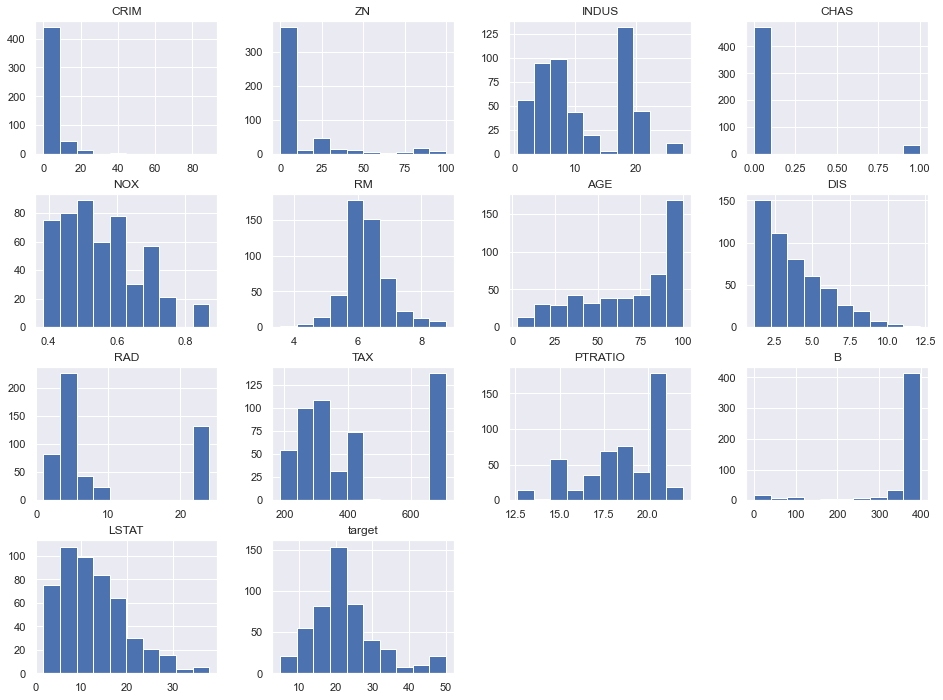

In [14]:
df.hist(figsize=(16, 12)); plt.show()

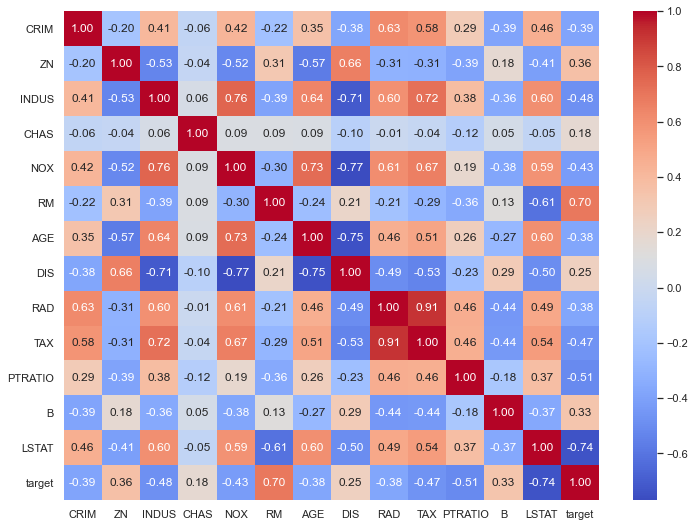

In [15]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df.corr(), fmt='.2f', annot=True, cmap='coolwarm'); plt.show()

## df00

In [16]:
df00 = df

## metrics00 : XGBR, LGBMR

In [17]:
# regression cross_validate : INPUT DF VERSION & TARGET
# ==================================================
df_met     = df00
target_met = 'target'
# ==================================================

# X, y split
train_met = df_met[df_met[target_met].notna()]
X_met = train_met.drop(target_met, axis=1)
y_met = train_met[target_met]

# estimators=
regressor_models = [
                    # LinearRegression(),
                    # RandomForestRegressor(random_state=0),
                    Ridge(random_state=0),
                    Lasso(random_state=0),
                    ElasticNet(random_state=0),
                    DecisionTreeRegressor(random_state=0),
                    XGBRegressor(random_state=0),
                    LGBMRegressor(random_state=0),
                    # CatBoostRegressor(random_state=0),
                    ]

# scorings=
regressor_scorers = {'MSE':'neg_mean_squared_error',
                     'RMSE':'neg_root_mean_squared_error',
                    #  'MSLE':'neg_mean_squared_log_error',
                    #  'MAE':'neg_mean_absolute_error',
                     }

# cv=
kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# cross_validate loop
for model in regressor_models:
    
    cv_results = cross_validate(model, X_met, y_met,
                                scoring=regressor_scorers,
                                cv=kf,
                                return_train_score=True, return_estimator=True)
    
    print('-' * 40)
    print('model  =', model.__class__.__name__)
    # print('params =', model.get_params(deep=True))
    
    # regression metrics
    print('MSE    = {}  '.format(- cv_results['test_MSE'].mean()), '\n'
          'RMSE   =  {}  '.format(- cv_results['test_RMSE'].mean()),
        #   'MSLE   = {}  '.format(- cv_results['test_MSLE'].mean()),
        #   'MAE    = {}  '.format(- cv_results['test_MAE'].mean()),
          )

----------------------------------------
model  = Ridge
MSE    = 24.104607729308043   
RMSE   =  4.862959672768154  
----------------------------------------
model  = Lasso
MSE    = 28.83896031809445   
RMSE   =  5.3252747234186995  
----------------------------------------
model  = ElasticNet
MSE    = 28.118247974108687   
RMSE   =  5.261013244999882  
----------------------------------------
model  = DecisionTreeRegressor
MSE    = 27.044324014754416   
RMSE   =  4.987576508226159  
----------------------------------------
model  = XGBRegressor
MSE    = 14.204296178776591   
RMSE   =  3.6698239615637327  
----------------------------------------
model  = LGBMRegressor
MSE    = 13.426938896742564   
RMSE   =  3.5583786467718994  


In [18]:
# regression GridsearchCV : INPUT DF VERSION & TARGET
# ==================================================
df_met     = df00
target_met = 'target'
# ==================================================

# X, y split
train_met = df_met[df_met[target_met].notna()]
X_met = train_met.drop(target_met, axis=1)
y_met = train_met[target_met]

# models
regressor_models = [
                    # LinearRegression(),
                    # RandomForestRegressor(),
                    Ridge(),
                    Lasso(),
                    ElasticNet(),
                    DecisionTreeRegressor(),
                    XGBRegressor(),
                    LGBMRegressor(),
                    # CatBoostRegressor(),
                    ]

# param_grid=
hyper_param = {
               'random_state':[0],
               }

# scoring=
regressor_scorers = {'MSE':'neg_mean_squared_error',
                     'RMSE':'neg_root_mean_squared_error',
                    #  'MSLE':'neg_mean_squared_log_error',
                    #  'MAE':'neg_mean_absolute_error',
                     }

# cv=
kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# cv_results_ cols
regression_cols = ['mean_test_MSE', 'mean_test_RMSE', 
                #    'mean_test_MSLE', 'mean_test_MAE',
                   ]

# GridSearchCV loop
for model in regressor_models:
        
        gscv = GridSearchCV(model, 
                            param_grid=hyper_param, 
                            scoring=regressor_scorers, refit='RMSE', 
                            cv=kf, return_train_score=True)
        gscv.fit(X_met, y_met)
        results = gscv.cv_results_
        
        print('-' * 40)
        print('estimtor        =', gscv.estimator.__class__.__name__)
        print('best_params_    =', gscv.best_params_)
        print('best_score_     =', - gscv.best_score_)
        
        met_df = pd.DataFrame(results)[regression_cols]
        met_df.columns = ['MSE', 'RMSE', 
                        #   'MSLE', 'MAE',
                          ]
        print(- met_df)

----------------------------------------
estimtor        = Ridge
best_params_    = {'random_state': 0}
best_score_     = 4.862959672768154
         MSE     RMSE
0  24.104608  4.86296
----------------------------------------
estimtor        = Lasso
best_params_    = {'random_state': 0}
best_score_     = 5.3252747234186995
        MSE      RMSE
0  28.83896  5.325275
----------------------------------------
estimtor        = ElasticNet
best_params_    = {'random_state': 0}
best_score_     = 5.261013244999882
         MSE      RMSE
0  28.118248  5.261013
----------------------------------------
estimtor        = DecisionTreeRegressor
best_params_    = {'random_state': 0}
best_score_     = 4.987576508226159
         MSE      RMSE
0  27.044324  4.987577
----------------------------------------
estimtor        = XGBRegressor
best_params_    = {'random_state': 0}
best_score_     = 3.6698239615637327
         MSE      RMSE
0  14.204296  3.669824
----------------------------------------
estimtor

In [19]:
gscv.cv_results_

{'mean_fit_time': array([0.06083398]),
 'std_fit_time': array([0.01170249]),
 'mean_score_time': array([0.00059862]),
 'std_score_time': array([0.00119724]),
 'param_random_state': masked_array(data=[0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'random_state': 0}],
 'split0_test_MSE': array([-24.49869673]),
 'split1_test_MSE': array([-6.0079822]),
 'split2_test_MSE': array([-13.68282113]),
 'split3_test_MSE': array([-14.99121429]),
 'split4_test_MSE': array([-7.95398013]),
 'mean_test_MSE': array([-13.4269389]),
 'std_test_MSE': array([6.48213623]),
 'rank_test_MSE': array([1]),
 'split0_train_MSE': array([-1.99686896]),
 'split1_train_MSE': array([-1.93405605]),
 'split2_train_MSE': array([-1.76728296]),
 'split3_train_MSE': array([-2.05121777]),
 'split4_train_MSE': array([-2.14973432]),
 'mean_train_MSE': array([-1.97983201]),
 'std_train_MSE': array([0.12769144]),
 'split0_test_RMSE': array([-4.94961582]),
 'split1_test_RMSE': arr

## df01 : drop outlier CRIM, B

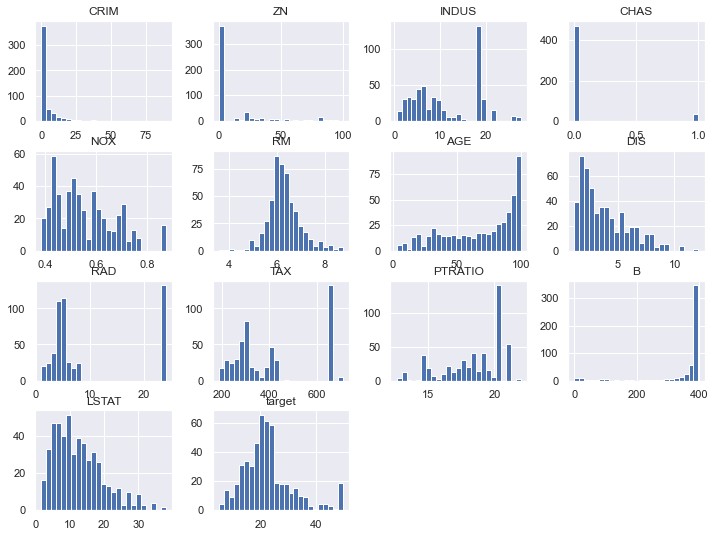

In [20]:
df01 = df
df01.hist(figsize=(12, 9), bins=25); plt.show()

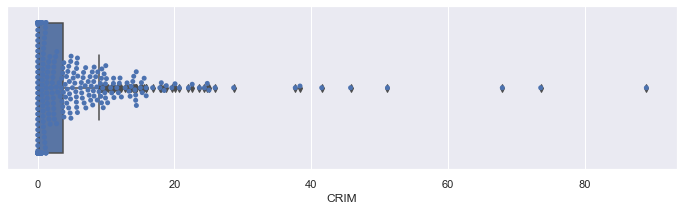

In [21]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(df01['CRIM'])
sns.swarmplot(x=df01['CRIM'])
plt.show()

In [22]:
df01.shape

(506, 14)

In [23]:
crim_dropidx = df01[df01['CRIM'] >= 60].index.values
df01 = df01.drop(crim_dropidx)
df01.shape

(503, 14)

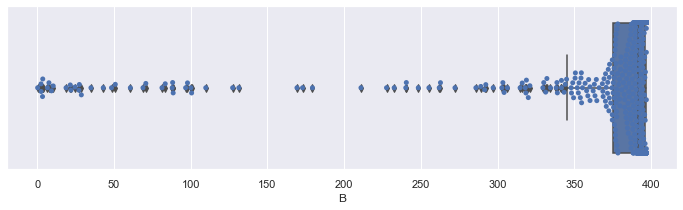

In [24]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(df01['B'])
sns.swarmplot(x=df01['B'])
plt.show()

In [25]:
b_dropidx = df01[df01['B'] < 150].index.values
df01 = df01.drop(b_dropidx)
df01.shape

(468, 14)

In [26]:
df01.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            496, 497, 498, 499, 500, 501, 502, 503, 504, 505],
           dtype='int64', length=468)

In [27]:
df01 = df01.reset_index(drop=True)
print(df01.shape)
df01.index

(468, 14)


RangeIndex(start=0, stop=468, step=1)

In [32]:
df01.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## metrics01 : outlier 개선

In [28]:
# regression cross_validate : INPUT DF VERSION & TARGET
# ==================================================
df_met     = df01
target_met = 'target'
# ==================================================

# X, y split
train_met = df_met[df_met[target_met].notna()]
X_met = train_met.drop(target_met, axis=1)
y_met = train_met[target_met]

# estimators=
regressor_models = [
                    # LinearRegression(),
                    # RandomForestRegressor(random_state=0),
                    # Ridge(random_state=0),
                    # Lasso(random_state=0),
                    # ElasticNet(random_state=0),
                    # DecisionTreeRegressor(random_state=0),
                    XGBRegressor(random_state=0),
                    LGBMRegressor(random_state=0),
                    # CatBoostRegressor(random_state=0),
                    ]

# scorings=
regressor_scorers = {'MSE':'neg_mean_squared_error',
                     'RMSE':'neg_root_mean_squared_error',
                    #  'MSLE':'neg_mean_squared_log_error',
                    #  'MAE':'neg_mean_absolute_error',
                     }

# cv=
kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# cross_validate loop
for model in regressor_models:
    
    cv_results = cross_validate(model, X_met, y_met,
                                scoring=regressor_scorers,
                                cv=kf,
                                return_train_score=True, return_estimator=True)
    
    print('-' * 40)
    print('model  =', model.__class__.__name__)
    # print('params =', model.get_params(deep=True))
    
    # regression metrics
    print('MSE    = {}  '.format(- cv_results['test_MSE'].mean()), '\n'
          'RMSE   =  {}  '.format(- cv_results['test_RMSE'].mean()),
        #   'MSLE   = {}  '.format(- cv_results['test_MSLE'].mean()),
        #   'MAE    = {}  '.format(- cv_results['test_MAE'].mean()),
          )

----------------------------------------
model  = XGBRegressor
MSE    = 11.314493110533654   
RMSE   =  3.287117512808911  
----------------------------------------
model  = LGBMRegressor
MSE    = 12.230808192401216   
RMSE   =  3.4377205711206558  


## df02 : df01 + log

In [29]:
df02 = df01
df02 = np.log(df02)

In [30]:
df02.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
target     0
dtype: int64

## metrics02

In [31]:
# regression cross_validate : INPUT DF VERSION & TARGET
# ==================================================
df_met     = df02
target_met = 'target'
# ==================================================

# X, y split
train_met = df_met[df_met[target_met].notna()]
X_met = train_met.drop(target_met, axis=1)
y_met = train_met[target_met]

# estimators=
regressor_models = [
                    # LinearRegression(),
                    # RandomForestRegressor(random_state=0),
                    # Ridge(random_state=0),
                    # Lasso(random_state=0),
                    # ElasticNet(random_state=0),
                    # DecisionTreeRegressor(random_state=0),
                    XGBRegressor(random_state=0),
                    LGBMRegressor(random_state=0),
                    # CatBoostRegressor(random_state=0),
                    ]

# scorings=
regressor_scorers = {'MSE':'neg_mean_squared_error',
                     'RMSE':'neg_root_mean_squared_error',
                    #  'MSLE':'neg_mean_squared_log_error',
                    #  'MAE':'neg_mean_absolute_error',
                     }

# cv=
kf  = KFold          (n_splits=5, shuffle=True, random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# cross_validate loop
for model in regressor_models:
    
    cv_results = cross_validate(model, X_met, y_met,
                                scoring=regressor_scorers,
                                cv=kf,
                                return_train_score=True, return_estimator=True)
    
    print('-' * 40)
    print('model  =', model.__class__.__name__)
    # print('params =', model.get_params(deep=True))
    
    # regression metrics
    print('MSE    = {}  '.format(- cv_results['test_MSE'].mean()), '\n'
          'RMSE   = {}  '.format(- cv_results['test_RMSE'].mean()),
        #   'MSLE   = {}  '.format(- cv_results['test_MSLE'].mean()),
        #   'MAE    = {}  '.format(- cv_results['test_MAE'].mean()),
          )

----------------------------------------
model  = XGBRegressor
MSE    = nan   
RMSE   = nan  
----------------------------------------
model  = LGBMRegressor
MSE    = 0.021602900268283147   
RMSE   = 0.14502042216070007  
